In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import yaml
import numpy as np
import requests

In [2]:
# download a fresh copy of the dataset from the OSF
data_url = 'https://osf.io/f76rb//?action=download'
response = requests.get(data_url)

if response.status_code == 200:
    with open('../../data/dat.csv', 'wb') as f:
        f.write(response.content)

In [3]:
PATH_TO_DATA = '../../data/dat.csv'
PATH_TO_INDEX_INTERPRETATIONS = '../../R/value_labels.yml'

In [4]:
consultation_data = pd.read_csv(PATH_TO_DATA)

In [5]:
variable_labels = pd.read_csv('../../data/Variabelen_DJA_shortlabels.csv', encoding='ISO-8859-1')
index_interpretations = yaml.safe_load(open(PATH_TO_INDEX_INTERPRETATIONS))

In [6]:
def get_labels(data_frame, variable_labels, index_interpretations, column_name):
    column_interpretation = variable_labels.loc[variable_labels['short']==column_name]['Label'].values[0]
    
    relevant_column_counts = data_frame[column_name].value_counts()
    
    index_interpretations_for_column = index_interpretations[column_name]
    
    labels = []
    column_counts_including_zeros = np.zeros(len(index_interpretations_for_column)-1)
    
    for key in index_interpretations_for_column.keys():
        if not key == 'class':
            index = int(key)
            
            if index in data_frame[column_name].unique():
                column_counts_including_zeros[index-1] = relevant_column_counts[index]
                
            try:
                current_label_interpretation = index_interpretations[column_name][key]
            except:
                current_label_interpretation = 'unknown'    

            labels.append(current_label_interpretation)
    
    return labels, column_interpretation, column_counts_including_zeros

In [7]:
def get_plotting_data(data_frame, variable_labels, index_interpretations, column_name):
    
    (labels, column_interpretation, relevant_column_counts_sorted) = get_labels(data_frame, variable_labels, index_interpretations, column_name)
    
    #values = relevant_column_counts_sorted.values
    
    return labels, relevant_column_counts_sorted, column_interpretation

In [8]:
def finalize_figure(column_interpretation, save_folder, prefix, column_name):
    if len(prefix) > 0:
        title = '%s\n%s' % (prefix, column_interpretation)
    else:
        title = column_interpretation
        
    plt.title(title)
    
    if len(save_folder) > 0:
        plt.savefig('%s/%s.png' % (save_folder, column_name), bbox_inches='tight')

In [9]:
def format_autopct(values):
    def autopct_formatted(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return autopct_formatted

In [10]:
def create_stacked_bar_chart(data_frame, variable_labels, index_interpretations, column_name_x, column_name_to_stack, save_folder = '', prefix = ''):
    (labels, column_interpretation, relevant_column_counts_sorted) = get_labels(data_frame, variable_labels, index_interpretations, column_name_x)
    
    regrouped_data = data_frame.groupby([column_name_x, column_name_to_stack])[column_name_x].count().unstack(column_name_to_stack)
    
    
    
    plt.figure()
    regrouped_data.plot(kind='bar', stacked=True)
    
    plt.xlabel('')
    plt.xticks(np.arange(0, len(labels)), labels=labels, rotation = 90)
    plt.legend(bbox_to_anchor=(1, 0.5) , loc='center left')
    
    finalize_figure(column_interpretation, save_folder, prefix, column_name_x)
    
    # return labels
    return regrouped_data

In [11]:
single_column_answers = ['major_changes']

<Figure size 640x480 with 0 Axes>

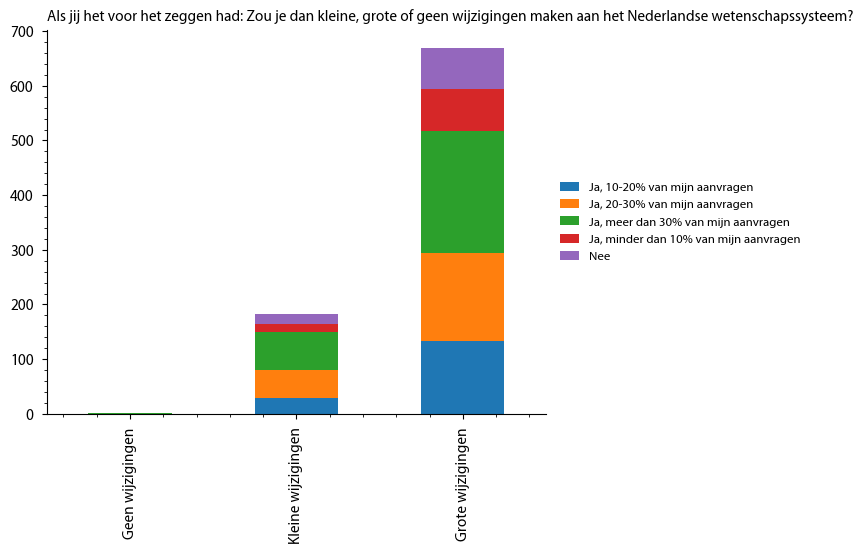

In [12]:
PLOTTING_FOLDER = 'plots_bar_stacked'
if not os.path.exists(PLOTTING_FOLDER):
    os.mkdir(PLOTTING_FOLDER)

df_fig12 = create_stacked_bar_chart(consultation_data, variable_labels, index_interpretations, 'major_changes', 'successful_applications', PLOTTING_FOLDER)

In [13]:
df_fig12 = df_fig12.rename({
    'Assistant/associate prof/UD (temporary contract)': 'Assistant / associate professor (no tenure)',
    'Assistant, associate (permanent)': 'Assistant / associate professor (tenured)',
    #'PhD': ,
    #'Postdoc':,
    'Hoogleraar/professor': 'Full professor',
    'Student-PhD-Postdoc-OA = ECR': 'Early career researcher'})
df_fig12

successful_applications,"Ja, 10-20% van mijn aanvragen","Ja, 20-30% van mijn aanvragen","Ja, meer dan 30% van mijn aanvragen","Ja, minder dan 10% van mijn aanvragen",Nee
major_changes,,,,,
1.0,NaN,NaN,2.0,NaN,NaN
2.0,28.0,53.0,69.0,15.0,18.0
3.0,133.0,161.0,223.0,78.0,74.0


In [14]:
df_fig12.to_excel("funding_consultation_final_plots_fig12.xlsx")